In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as cmo
import xarray as xr
import os
from collections import defaultdict
from glob import glob
from scipy.signal import detrend
from scipy.stats import skew, mode
import scipy
import seaborn as sns
import random
import pandas as pd

# -------------   Plotting Style --------------------------
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

styles = ["-", '--', '-.', ':', '-']
plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [15, 10]
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=4)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Paired.colors)

# -------------   META DATA ABOUT MODELS --------------------------
meta = {
    "ACCESS-ESM1-5": {"ecs": 3.87, "res": 108000}, #300*360; https://www.publish.csiro.au/es/ES19035
    "ACCESS-CM2": {"ecs": 4.7, "res": 108000}, #300*360; https://www.publish.csiro.au/ES/justaccepted/ES21031
    "CNRM-CM6-1": {"ecs": 4.90, "erf": 3.64, "pl": -3.29, "lr": -0.42, "wv": 1.75, "alb": 0.53, "cld_sw": -0.02, "cld_lw": 0.57, "net": -.74, "res":106428}, #294*362
    "MPI-ESM1-2-LR": {"ecs": 2.98, "erf": 3.65, "pl": -3.20, "lr": -0.53, "wv": 1.83, "alb": 0.42, "cld_sw": -0.41, "cld_lw": 0.61, "net": -1.22, "res": 56320}, #256*220
    "MPI-ESM1-2-HR": {"ecs": 2.98, "erf": 3.65, "pl": -3.20, "lr": -0.53, "wv": 1.83, "alb": 0.42, "cld_sw": -0.41, "cld_lw": 0.61, "net": -1.22, "res": 324008}, #802*404
    "CESM2": {"ecs": 5.15, "erf": 3.26, "pl": -3.34, "lr": -0.53, "wv": 1.87, "alb": 0.41, "cld_sw": 0.80, "cld_lw": 0.17, "net": -0.63, "res":122880}, #320*384
    "MPI-ESM": {"ecs": 3.46, "erf": 4.26, "pl": -3.24, "lr": -0.79, "wv": 1.97, "alb": 0.43, "cld_sw": -0.21, "cld_lw": 0.53, "net": -1.23, "res": 56320}, #220*256
    # "CanESM2": {"ecs": 3.70, "erf": 3.81, "pl": -3.34, "lr": -0.44, "wv": 1.87, "alb": 0.45, "cld_sw": -0.29, "cld_lw": 0.74, "net": -1.03, "start": 1950, "res": 8192}, #64*128
    "MIROC6": {"ecs": 2.60, "erf": 3.65, "pl": -3.34, "lr": -0.64, "wv": 2.03, "alb": 0.51, "cld_sw": -0.13, "cld_lw": 0.25, "net": -1.40, "res": 92160}, #360*256
    # "CESM1-CAM5": {"ecs": 4.0, "start": 1920, "res":122880}, #384*320; https://agupubs.onlinelibrary.wiley.com/doi/pdfdirect/10.1029/2019GL083978
    "CanESM5i1p1f1": {"ecs": 5.64, "erf": 3.68, "pl": -3.33, "lr": -0.61, "wv": 1.97, "alb": 0.47, "cld_sw": 0.80, "cld_lw": 0.25, "net": -0.65, "res":104760}, # 291*360
    "CanESM5_i1p2f1": {"ecs": 5.64, "erf": 3.68, "pl": -3.33, "lr": -0.61, "wv": 1.97, "alb": 0.47, "cld_sw": 0.80, "cld_lw": 0.25, "net": -0.65, "res":104760}, #291*360
    # "GFDL-CM3": {"ecs": 3.96, "start": 1920}, 
    "MIROC-ES2L": {"ecs": 2.66, "erf": 4.11, "pl": -3.31, "lr": -0.70, "wv": 1.98, "alb": 0.44, "cld_sw": -0.35, "cld_lw": 0.32, "net": -1.54, "res": 92160} # 256*360
}
    # "CESM1": 4.0, #https://agupubs.onlinelibrary.wiley.com/doi/pdfdirect/10.1029/2019GL083978
    # "FGOALS-g3": 2.98,
    # "NorESM2-LM": 2.56,
    # "GFDL-ESM2M": 2.44,
    # "CSIRO-Mk3-6-0": 4.09,
    # "IPSL-CM6A-LR": 4.56,
    
exps = ["rcp26", "rcp45", "rcp85", "ssp126", "ssp245", "ssp370", "ssp585"]

c1 = ["#9ecae1","#6baed6", "#3182bd","#08519c"]
c2 = ["#a1d99b","#74c476","#31a354", "#006d2c"]
c1.reverse()
c2.reverse()

### Utils

In [15]:
def moving_average(x, w=1):
    return np.convolve(x, np.ones(w), 'valid') / w

### Load obs

In [16]:
def load_obs(path):
    # Initialize
    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    obs = {
        "NH": np.zeros((12, 2021-1979)), 
        "SH": np.zeros((12, 2021-1979))
    }
    
    # Load Data
    xlsx = pd.ExcelFile(path)
    for hem in ["NH", "SH"]:
        for i, mon in enumerate(months): 
            obs[hem][i,:] = pd.read_excel(xlsx, f'{mon}-{hem}').to_numpy()[9:9+(2021-1979),6]
    return obs
 
path = os.path.join("/glade/scratch/zespinosa/cmip6LE/obs", "Sea_Ice_Index_Monthly_Data_with_Statistics_G02135_v3.0.xlsx")
obs = load_obs(path)

##################### Fill NANs #############################: 
# This is a temporary fix that interpolated nearest values
obs["NH"][7][8] = 4.90
obs["NH"][0][9] = 12.50
obs["NH"][11][9] = 11.50
obs["SH"][11][9] =  7.0
obs["SH"][0][9] = 3.3

### Sanity Check Obs

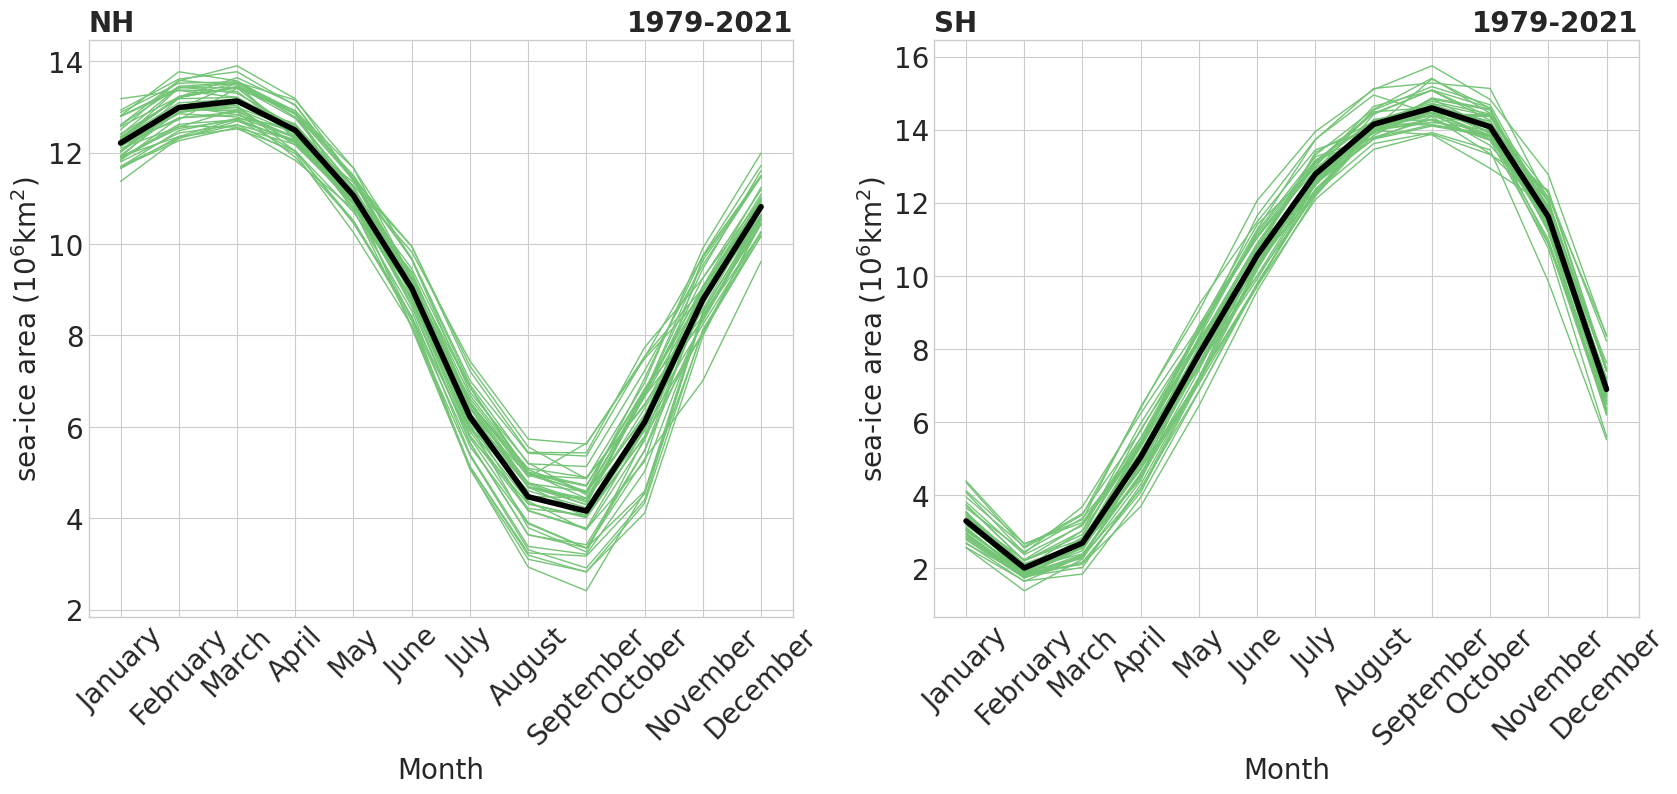

In [17]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

def plot_seasonal_cycle(): 
    nmon, nens = obs["NH"].shape
    fig, (ax1, ax2) = plt.subplots(1,2)
    for i in range(nens): 
        ax1.plot(np.arange(12), obs["NH"][:,i], color=c2[2], linewidth=1)
        ax2.plot(np.arange(12), obs["SH"][:,i], color=c2[2], linewidth=1)

    ax1.plot(np.arange(12), np.nanmean(obs["NH"], axis=1), color='black')
    ax2.plot(np.arange(12), np.nanmean(obs["SH"], axis=1), color='black')

    ax1.set_xlabel("Month")
    ax1.set_ylabel(r"sea-ice area ($10^6$km$^2$)")
    ax1.set_xticks(np.arange(12))
    ax1.set_xticklabels(months, rotation=45)
    ax1.set_title("NH", fontweight="bold", loc="left")
    ax1.set_title("1979-2021", fontweight="bold", loc="right")

    ax2.set_xlabel("Month")
    ax2.set_ylabel(r"sea-ice area ($10^6$km$^2$)")
    ax2.set_xticks(np.arange(12))
    ax2.set_xticklabels(months, rotation=45)
    ax2.set_title("SH", fontweight="bold", loc="left")
    ax2.set_title("1979-2021", fontweight="bold", loc="right")
    
    fig.set_size_inches(20, 7.5)

## Calc Variability
def calc_obs_std(W=36): 
    obs["NH_std"], obs["SH_std"] = [], []
    for i in range(2021-1979-W):
        NH_slice = detrend(obs["NH"][:,i:i+W], axis=1)
        obs["NH_std"].append(np.std(NH_slice, axis=1))

        SH_slice = detrend(obs["SH"][:,i:i+W], axis=1)
        obs["SH_std"].append(np.std(SH_slice, axis=1))

plot_seasonal_cycle()
calc_obs_std()
    

## Load Data

In [19]:
droot = "/glade/scratch/zespinosa/cmip6LE/processed/"
siArea = defaultdict(lambda: {})

for model in meta.keys(): 
    siArea[model]["siareaN"], siArea[model]["siareaS"] = {}, {}
    for exp in exps:
        try: 
            nh_files = glob(os.path.join(droot, f"siarea_nh_historical_{exp}_{model}*.nc"))
            if len(nh_files) == 1:
                siArea[model]["siareaN"][exp] = defaultdict(lambda: {})
                siArea[model]["siareaN"][exp]["data"] = xr.open_dataset(nh_files[0]).to_array()[0]/1e12
                siArea[model]["siareaN"][exp]["dates"] = xr.open_dataset(nh_files[0]).to_array()[0]/1e12

                
                siArea[model]["siareaN"]["stdMax"] = np.empty(12)
                siArea[model]["siareaN"]["meanMax"] = np.empty(12)
                siArea[model]["siareaN"]["mean_total"] = {}
                siArea[model]["siareaN"]["std_total"] = {}
            
            sh_files = glob(os.path.join(droot, f"siarea_sh_historical_{exp}_{model}*.nc"))
            if len(sh_files) == 1:  
                siArea[model]["siareaS"][exp] = defaultdict(lambda: {})
                siArea[model]["siareaS"][exp]["data"] = xr.open_dataset(sh_files[0]).to_array()[0]/1e12 
                
                siArea[model]["siareaS"]["stdMax"] = np.empty(12)
                siArea[model]["siareaS"]["meanMax"] = np.empty(12)
                siArea[model]["siareaS"]["mean_total"] = {}
                siArea[model]["siareaS"]["std_total"] = {}
            
            if len(nh_files) == 1: 
                nensm = siArea[model]["siareaN"][exp]["data"].shape[0]
                print(f"{model} {exp} {nensm} ensemble members")
            
        except Exception as err:
            print(f"{model} {exp} failed! \n {err}")
        

ACCESS-ESM1-5 ssp126 40 ensemble members
ACCESS-ESM1-5 ssp245 40 ensemble members
ACCESS-ESM1-5 ssp370 40 ensemble members
ACCESS-ESM1-5 ssp585 40 ensemble members
ACCESS-CM2 ssp126 5 ensemble members
ACCESS-CM2 ssp245 5 ensemble members
ACCESS-CM2 ssp370 5 ensemble members
ACCESS-CM2 ssp585 5 ensemble members
CNRM-CM6-1 ssp126 6 ensemble members
CNRM-CM6-1 ssp245 6 ensemble members
CNRM-CM6-1 ssp370 6 ensemble members
CNRM-CM6-1 ssp585 6 ensemble members
MPI-ESM1-2-LR ssp126 30 ensemble members
MPI-ESM1-2-LR ssp245 30 ensemble members
MPI-ESM1-2-LR ssp370 30 ensemble members
MPI-ESM1-2-LR ssp585 30 ensemble members
MPI-ESM1-2-HR ssp126 2 ensemble members
MPI-ESM1-2-HR ssp245 2 ensemble members
MPI-ESM1-2-HR ssp370 10 ensemble members
MPI-ESM1-2-HR ssp585 2 ensemble members
CESM2 ssp370 50 ensemble members
MPI-ESM rcp26 100 ensemble members
MPI-ESM rcp85 100 ensemble members
MIROC6 ssp126 50 ensemble members
MIROC6 ssp370 3 ensemble members
MIROC6 ssp585 50 ensemble members
CanESM5i1p1

### Sanity Check Time-series

In [16]:
def plot_mean_trend(model):
    monN, monS, nmon, i = 8, 2, 12, 0
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for exp in exps: 
        
        # Check if experiment is part of model
        if exp not in siArea[model]["siareaN"].keys(): continue
        dfN = siArea[model]["siareaN"][exp]["data"]
        dfS = siArea[model]["siareaS"][exp]["data"]
        
        nens, ntime = dfN.shape
        # if nens < 10: continue
        time = np.arange(ntime/nmon)

        # Antarctic SIE
        # for i in range(nens): plt.plot(time, dfS[i,monS::12],color="#9ecae1")
        std = np.std(dfS[:,monS::12], axis=0)
        avg = np.average(dfS[:,monS::12], axis=0)
        ax1.fill_between(time, avg+std, avg-std, alpha = 0.2, color = c1[i])
        ax1.plot(time, avg, color=c1[i], label=f"{exp}")

        # Arctic SIE
        std = np.std(dfN[:,monN::12], axis=0)
        avg = np.average(dfN[:,monN::12], axis=0)
        ax2.fill_between(time, avg+std, avg-std, alpha = 0.2, color = c2[i])
        ax2.plot(time, np.average(dfN[:,monN::12], axis=0), color=c2[i], label=f"{exp} ({nens})")
        i += 1

    print(model)
    if "start" in meta[model].keys(): 
        date = meta[model]["start"]
    else: 
        date = 1850
    ax1.set_xticks(np.arange(0,ntime/nmon,30))
    ax1.set_xticklabels(np.arange(date, int(ntime/nmon)+date, 30))
    ax1.legend()
    ax1.set_ylabel(r"Summer SIE (10$^6$ km$^2$)")
    ax1.set_xlabel(r"Year")
    ax1.set_title(f"Antarctica ({model})", loc="right")
    
    ax2.set_xticks(np.arange(0,ntime/nmon,30))
    ax2.set_xticklabels(np.arange(date, int(ntime/nmon)+date, 30))
    ax2.legend()
    ax2.set_ylabel(r"Summer SIE (10$^6$ km$^2$)")
    ax2.set_xlabel(r"Year")
    ax2.set_title(f"Arctic ({model})", loc="right")

    
    fig.set_size_inches(25, 10)

# def plot_ssp370(model):
    
    
# for model in meta.keys():
    # plot_mean_trend(model)

## Calculate and Save Ensemble Data

In [20]:
W = 20
sizeSample = 5
totalSamples = 5
nmonths = 12 
cmodels = []
for model in meta.keys():
        
    for hem in ["siareaN", "siareaS"]:
        # Iterate through experiments
        for exp in exps: 
            # Check if experiment is part of model
            if exp not in siArea[model][hem].keys(): continue
                
            nens, time = siArea[model][hem][exp]["data"].shape
            nyears = int(time/nmonths)

            if nens < totalSamples: continue
            
            print(f"Starting {model} {exp} {hem}")

            cmodels.append(model)
            # Extract Monte Carlo sample of size sizeSample from totalSamples
            sample = random.sample(range(nens), sizeSample)
            siarea_monthly = siArea[model][hem][exp]["data"][sample,:]
            siarea_monthly = siarea_monthly.values.reshape(sizeSample, nyears, nmonths)
               
            newShape = (nmonths, nyears-W)
            # Initialize Data Objects
            siArea[model][hem][exp]["std"] = np.empty(newShape)
            siArea[model][hem][exp]["skew"] = np.empty(newShape)
            siArea[model][hem][exp]["mean"] = np.empty(newShape)
            siArea[model][hem][exp]["mode"] = np.empty(newShape)
            siArea[model][hem][exp]["median"] = np.empty(newShape)
                   
            # Iterate through years for each season
            for i in range(nyears-W):
                # Detrend time series of window size W
                wd = siarea_monthly[:,i:i+W,:]
                ts = detrend(wd, axis=1)
                # Summary stats
                siArea[model][hem][exp]["std"][:,i] = np.std(ts, axis=(0,1))
                siArea[model][hem][exp]["skew"][:,i] = skew(ts.reshape(wd.shape[0]*wd.shape[1], wd.shape[2]), axis=(0))
                siArea[model][hem][exp]["mean"][:,i] = np.mean(wd, axis=(0,1))
                siArea[model][hem][exp]["median"][:,i] = np.median(wd, axis=(0,1))
            
cmodels = np.unique(cmodels)
print("Done!")

Starting ACCESS-ESM1-5 ssp126 siareaN
Starting ACCESS-ESM1-5 ssp245 siareaN
Starting ACCESS-ESM1-5 ssp370 siareaN
Starting ACCESS-ESM1-5 ssp585 siareaN
Starting ACCESS-ESM1-5 ssp126 siareaS
Starting ACCESS-ESM1-5 ssp245 siareaS
Starting ACCESS-ESM1-5 ssp370 siareaS
Starting ACCESS-ESM1-5 ssp585 siareaS
Starting ACCESS-CM2 ssp126 siareaN
Starting ACCESS-CM2 ssp245 siareaN
Starting ACCESS-CM2 ssp370 siareaN
Starting ACCESS-CM2 ssp585 siareaN
Starting ACCESS-CM2 ssp126 siareaS
Starting ACCESS-CM2 ssp245 siareaS
Starting ACCESS-CM2 ssp370 siareaS
Starting ACCESS-CM2 ssp585 siareaS
Starting CNRM-CM6-1 ssp126 siareaN
Starting CNRM-CM6-1 ssp245 siareaN
Starting CNRM-CM6-1 ssp370 siareaN
Starting CNRM-CM6-1 ssp585 siareaN
Starting CNRM-CM6-1 ssp126 siareaS
Starting CNRM-CM6-1 ssp245 siareaS
Starting CNRM-CM6-1 ssp370 siareaS
Starting CNRM-CM6-1 ssp585 siareaS
Starting MPI-ESM1-2-LR ssp126 siareaN
Starting MPI-ESM1-2-LR ssp245 siareaN
Starting MPI-ESM1-2-LR ssp370 siareaN
Starting MPI-ESM1-2-LR

# Visualize

### Variability vs Mean State

In [37]:
def plot_siev(hem, season, window, save, sp):
    fig, axs = plt.subplots(len(list(cmodels)) + 1, 1)
    for i, model in enumerate(cmodels):
        mean_total = []
        std_total = []
        # try:
        if True: 
            for exp in exps: 
                if exp not in siArea[model][hem].keys(): continue
                try: 
                # if True:
                    mean = siArea[model][hem][exp]["mean"][season,:]
                    std = siArea[model][hem][exp]["std"][season,:]
                    mean_total = mean_total + list(mean)
                    std_total = std_total + list(std)
                    nens, _ = siArea[model][hem][exp]["data"].shape
                    axs[i].scatter(mean, std, label=f"{model} {exp} (n={10})")    
                except Exception as err:
                    # pass
                    # import pdb; pdb.set_trace()
                    print(f"{model} {exp} failed! {err} \n")

            p = np.array(mean_total).argsort()
            mean_total = moving_average(np.array(mean_total)[p], w=window)
            std_total = moving_average(np.array(std_total)[p], w=window)

            # Save max STD and location of max STD for future use
            idx = np.argmax(std_total)
            siArea[model][hem]["mean_total"][season] = mean_total
            siArea[model][hem]["std_total"][season] = std_total
            siArea[model][hem]["stdMax"][season] = std_total[idx]
            siArea[model][hem]["meanMax"][season] = mean_total[idx]

            axs[i].plot(mean_total, std_total, label=f"Total (smoothed={window})", color="black")
            ecs = meta[model]["ecs"]
            axs[-1].scatter(mean_total, std_total, label=f"{model} ({ecs})")
            axs[i].legend()
            axs[i].set_xlabel(r"Mean 10$^6$ km$^2$")
            axs[i].set_ylabel(r"$\sigma$ (10$^6$ km$^2$)")
            axs[i].set_title(f"{model}, ECS={ecs}", loc="right")
        
        # except Exception as err:
            # pass
            # print(f"{model} {exp} failed! \n {err}")

    axs[-1].legend()
    axs[-1].set_xlabel(r"Mean 10$^6$ km$^2$")
    axs[-1].set_ylabel(r"$\sigma$ (10$^6$ km$^2$)")
    # plt.suptitle(f"Arctic STD Interannual Summer SIA (window={W})")
    fig.set_size_inches(12, 80)
    if save: plt.savefig(f"{sp}.png")
    plt.close()

### Max Variability vs Effective Climate Sensitivity

In [19]:
def plot_max(season, hem, sp):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    ecs, mean, std, cmodels = [], [], [], []
    for model in meta.keys():
        if model == "ACCESS-CM2" or model == "CNRM-CM6-1": continue #  or model == "CanESM5_i1p2f1"
        ecs.append(meta[model]["ecs"])
        mean.append(siArea[model][hem]["meanMax"][season])
        std.append(siArea[model][hem]["stdMax"][season])
        cmodels.append(model)

    # -------- STD vs ECS ------------
    for i in range(len(ecs)): ax1.scatter(ecs[i], std[i], label=cmodels[i])
    ax1.set_xlabel(r"Effective Climate Sensitivity (K)")
    ax1.set_ylabel("Max Standard Deviation $\sigma$ ($10^6$km$^2)$")
    # ax1.set_ylim(0.2,.9)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ecs, std)
    ax1.plot(ecs, slope*np.array(ecs) + intercept, label=r"R$^2=$" + f"{np.around(r_value**2, 2)}")
    ax1.legend()

    # -------- Mean vs ECS ------------
    for i in range(len(ecs)): ax2.scatter(ecs[i], mean[i], label=cmodels[i])
    ax2.set_xlabel(r"Effective Climate Sensitivity (K)")
    ax2.set_ylabel("Max SIA $\mu$ ($10^6$km$^2)$")
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ecs, mean)
    ax2.plot(ecs, slope*np.array(ecs) + intercept, label=r"R$^2=$" + f"{np.around(r_value**2, 2)}")
    ax2.legend()
    fig.set_size_inches(24.5, 6.5)
    plt.savefig(f"{sp}")
    plt.close()

In [38]:
seasons = {"January": 0, "February": 1, "March": 2, "April": 3, "May": 4, "June": 5, "July": 6, "August": 7, "September": 8, "October": 9, "November": 10, "December": 11}
# seasons = {"March": 2,"June": 5,"September": 8,"December": 11}
# seasons = {"September": 8}
window = 20
for hem in ["siareaN", "siareaS"]:
    for mon, season in seasons.items():
        plot_siev(hem=hem, season=season, window=window, save=False, sp=f"{hem}_siev_{mon}.png")
        # plot_max(season=season, hem=hem, sp=f"{hem}_max_{mon}.png")

MIROC6 ssp370 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp126 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp245 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp585 failed! unhashable type: 'slice' 

MIROC6 ssp370 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp126 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp245 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp585 failed! unhashable type: 'slice' 

MIROC6 ssp370 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp126 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp245 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp585 failed! unhashable type: 'slice' 

MIROC6 ssp370 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp126 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp245 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp585 failed! unhashable type: 'slice' 

MIROC6 ssp370 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp126 failed! unhashable type: 'slice' 

MPI-ESM1-2-HR ssp245 failed

### Plot Normalized Trend in variability

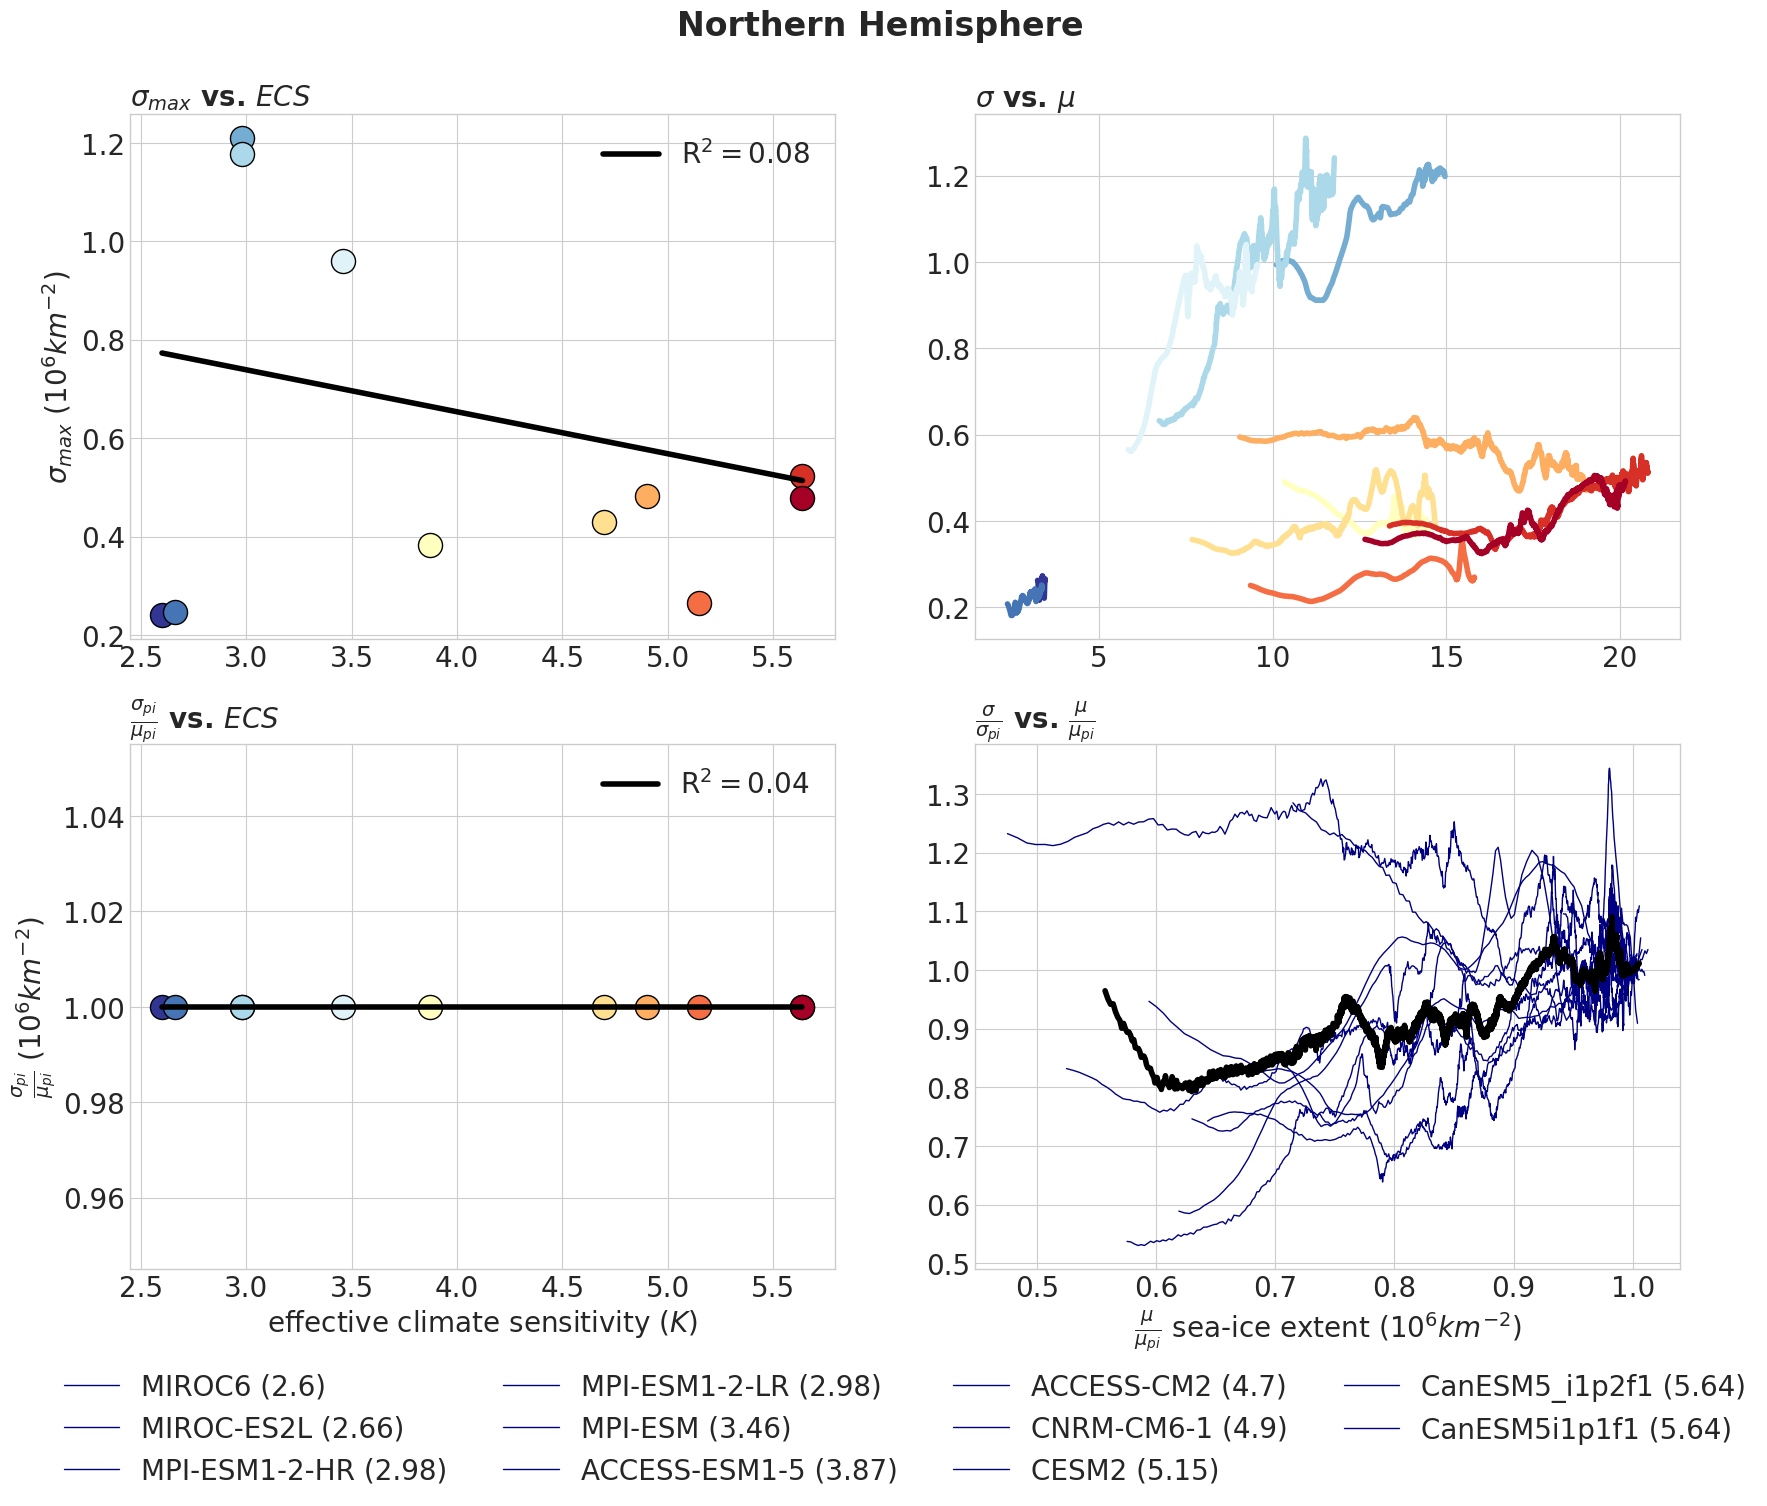

In [41]:
nwindow = 30
fig, axs = plt.subplots(2,2)
ecss, stdsNorm, stdsRaw = [], [], []
meanRaw = []
hem = "siareaS"
season = 8

# Get model ECS
# colors = ['#081d58','#253494','#225ea8','#1d91c0','#41b6c4','#7fcdbb','#c7e9b4','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026']
colors = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffbf','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']
colors.reverse()
for i, model in enumerate(cmodels): ecss.append(meta[model]["ecs"])
ecss, cmodels = zip(*sorted(zip(ecss, cmodels)))

highECS = []
lowECS = []
highECSMean = []
lowECSMean = []

# Plot ECS vs. meanState SIA
for i, model in enumerate(cmodels):
    mean = siArea[model][hem]["mean_total"][season]
    std = siArea[model][hem]["std_total"][season]
    mean, std = zip(*sorted(zip(mean,std)))
    
    ecs = ecss[i]
    # meanMax = siArea[model][hem]["meanMax"][season]
    meanMax = np.average(mean[-nwindow:])

    meanRaw.append(meanMax)
    
    # Plot Unnormalized Trends
    stdMax = siArea[model][hem]["stdMax"][season]
    stdsRaw.append(stdMax)
    stdMax = np.average(std[-nwindow:])
    axs[0][1].plot(mean, std, label=f"{model} ({ecs})", c=colors[i])
    axs[0][0].scatter(ecs, stdMax, s=300, color=colors[i], edgecolor="black")
    
    # Plot Normalized Trends
    std = np.array(std)/stdMax #(np.pi*np.array(mean)**(1/2)) #np.average(mean[-nwindow:]) #/np.average(std[-nwindow:])
    mean = mean/np.average(mean[-nwindow:])
    # axs[0][1].plot(mean, std, label=f"{model} ({ecs})", color=colors[i])
        
    stdMax = np.max(std)
    stdPi = np.average(std[-nwindow:])
    stdsNorm.append(stdPi)
    # if model == "CNRM-CM6-1": continue
    
    if ecs > 0: #3.5: 
        highECS += list(std)
        highECSMean += list(mean)
    else: 
        lowECS += list(std)
        lowECSMean += list(mean)
    axs[1][1].plot(mean, std, label=f"{model} ({ecs})", linewidth=1, color="navy")#colors[i])
    axs[1][0].scatter(ecs, stdPi, s=300, color=colors[i], edgecolor="black")  

slope, intercept, r_value, _, _ = scipy.stats.linregress(ecss, stdsNorm)
axs[1][0].plot(ecss, slope*np.array(ecss) + intercept, label=r"R$^2=$" + f"{np.around(r_value**2, 2)}", color="black")

slope, intercept, r_value, _, _ = scipy.stats.linregress(ecss, stdsRaw)
axs[0][0].plot(ecss, slope*np.array(ecss) + intercept, label=r"R$^2=$" + f"{np.around(r_value**2, 2)}", color="black")

# slope, intercept, r_value, _, _ = scipy.stats.linregress(ecss, meanRaw)
# axs[0][0].plot(ecss, slope*np.array(ecss) + intercept, label=r"R$^2=$" + f"{np.around(r_value**2, 2)}", color="black")
    
# Add labels
# axs[0][0].set_ylabel(r"$\mu_{pi}$ ($10^6 km^{-2}$)")
axs[0][0].set_ylabel(r"$\sigma_{max}$ ($10^6 km^{-2}$)")

# axs[1][0].set_ylabel(r"$\frac{\sigma_{max}}{\sigma_{pi}}$ ($10^6 km^{-2}$)")
# axs[1][0].set_ylabel(r"$\frac{\sigma_{max}}{\mu_{pi}}$ ($10^6 km^{-2}$)")
axs[1][0].set_ylabel(r"$\frac{\sigma_{pi}}{\mu_{pi}}$ ($10^6 km^{-2}$)")
# axs[1][0].set_ylabel(r"$\sigma_{pi}$ ($10^6 km^{-2}$)")

axs[1][0].set_xlabel(r"effective climate sensitivity ($K$)")
axs[1][1].set_xlabel(r"$\frac{\mu}{\mu_{pi}}$ sea-ice extent ($10^6 km^{-2}$)")


# axs[0][0].set_title(r"$\mu_{pi}$ vs. $ECS$", loc="left", fontweight="bold")
axs[0][0].set_title(r"$\sigma_{max}$ vs. $ECS$", loc="left", fontweight="bold")


# axs[1][0].set_title(r"$\frac{\sigma_{max}}{\sigma_{pi}}$ vs. $ECS$", loc="left", fontweight="bold")
axs[1][0].set_title(r"$\frac{\sigma_{pi}}{\mu_{pi}}$ vs. $ECS$", loc="left", fontweight="bold")
# axs[1][0].set_title(r"$\frac{\sigma_{max}}{\mu_{pi}}$ vs. $ECS$", loc="left", fontweight="bold")
# axs[1][0].set_title(r"$\sigma_{pi}$ vs. $ECS$", loc="left", fontweight="bold")

axs[0][1].set_title(r"$\sigma$ vs. $\mu$", loc="left", fontweight="bold")
# axs[1][1].set_title(r"$\frac{\sigma}{\sigma_{pi}}$ vs. $\frac{\mu}{\mu_{pi}}$", loc="left", fontweight="bold")
axs[1][1].set_title(r"$\frac{\sigma}{\sigma_{pi}}$ vs. $\frac{\mu}{\mu_{pi}}$", loc="left", fontweight="bold")
# axs[1][1].set_ylim(-0.1,1.5)
# axs[1][1].set_ylim(0.0,.6)

highECSMean, highECS = zip(*sorted(zip(highECSMean,highECS)))
# lowECSMean, lowECS = zip(*sorted(zip(lowECSMean,lowECS)))

highECSMean = moving_average(highECSMean, w=50)
highECS = moving_average(highECS, w=50)
# lowECSMean = moving_average(lowECSMean, w=50)
# lowECS = moving_average(lowECS, w=50)

axs[1][1].plot(highECSMean, highECS, color="black")
# axs[1][1].plot(lowECSMean, lowECS, color="black")


plt.suptitle("Northern Hemisphere", x=.5, y=.95, fontweight="bold")

axs[0][0].legend()
axs[1][0].legend()
axs[1][1].legend(loc='upper center', bbox_to_anchor=(-.1, -.15), ncol=4)
fig.set_size_inches(20, 15)

### Feedbacks

In [9]:
ecss, stdsNorm, stdsRaw = [], [], []
cecs = []
fbs = []
fbName = "wv"

# Get model ECS
colors = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffbf','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']
colors.reverse()
for i, model in enumerate(cmodels): ecss.append(meta[model]["ecs"])
ecss, cmodels = zip(*sorted(zip(ecss, cmodels)))

for i, model in enumerate(cmodels):
    if fbName not in meta[model].keys(): continue
    print(model)
    fb, ecs = meta[model][fbName], ecss[i]
    fbs.append(fb), cecs.append(ecs)
    plt.scatter(ecss[i], fb, s=300, color=colors[i], edgecolor="black")
    
slope, intercept, r_value, _, _ = scipy.stats.linregress(cecs, fbs)
plt.plot(ecss, slope*np.array(ecss) + intercept, label=r"R$^2=$" + f"{np.around(r_value**2, 2)}", color="black")
plt.legend() 
# Add labels
plt.xlabel(r"effective climate sensitivity ($K$)")
plt.ylabel(r"Water Vapor Feedback ($Wm^{-2}$)")
plt.title("Water Vapor Feedback", fontweight="bold")
fig.tight_layout()
#"CNRM-CM6-1": {"ecs": 4.90, "erf": 3.64, "pl": -3.29, "lr": -0.42, "wv": 1.75, "alb": 0.53, "cld_sw": -0.02, "cld_lw": 0.57, "net": -.74, "res":106428}, #294*362



NameError: name 'cmodels' is not defined

## Seasonlity of Variability

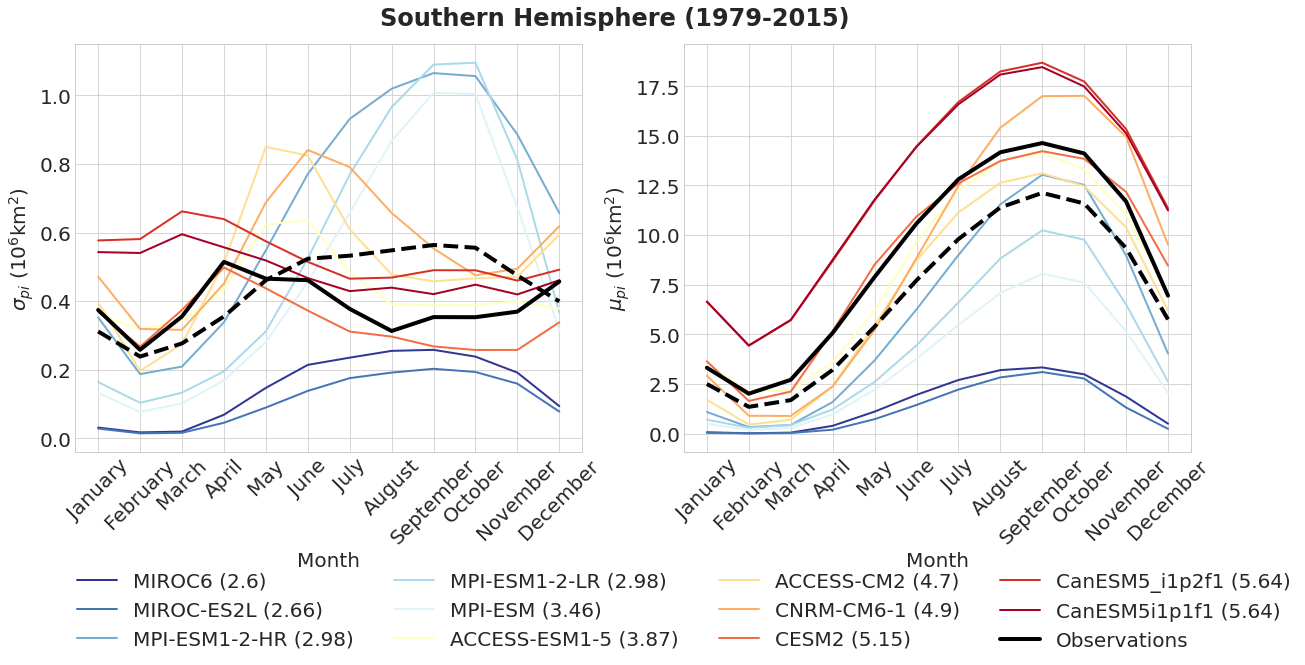

In [13]:
seasons = {"January": 0, "February": 1, "March": 2, "April": 3, "May": 4, "June": 5, "July": 6, "August": 7, "September": 8, "October": 9, "November": 10, "December": 11}
yearStart = 1979-1850-10
yearEnd = 2015-1850-10

ecss = []
colors = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffbf','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']
colors.reverse()
for i, model in enumerate(cmodels): ecss.append(meta[model]["ecs"])
ecss, cmodels = zip(*sorted(zip(ecss, cmodels)))

fig, (ax1, ax2) = plt.subplots(1,2)
stds, mus, musNorm = np.zeros((len(cmodels), 12)), np.zeros((len(cmodels), 12)), np.zeros((len(cmodels), 12)) 
for i, model in enumerate(cmodels):
    # if model == "CESM2": continue
    for hem in ["siareaS"]:
        # try:
        if True:
            exp = list(siArea[model][hem].keys())[0]
            if model == "MPI-ESM1-2-HR": exp = "ssp370"
            
            # std = np.average(siArea[model][hem][exp]["std"][:,yearStart:yearStart+20], axis=1) #/np.average(siArea[model][hem][exp]["mean"][:,yearStart:yearStart+20])
            
            std = np.average(siArea[model][hem][exp]["std"][:,yearStart:yearEnd], axis=1)
            mu = np.average(siArea[model][hem][exp]["mean"][:,yearStart:yearEnd], axis=1)
            
            stds[i,:] = std #/mu
            mus[i, :] = mu
            musNorm[i,:] = mu/meta[model]["ecs"]**3
            
            ax1.plot(np.arange(12), std, label=f"{model} ({ecss[i]})", linewidth=2, color=colors[i])
            ax2.plot(np.arange(12), mu, label=f"{model} ({ecss[i]})", linewidth=2, color=colors[i])

        # except Exception as err:
            # import pdb; pdb.set_trace()
            # print(err)
            # print(f"{model}")

# Observations
ax1.plot(np.arange(12), obs["SH_std"][0], label=f"Observations", color="black")
ax2.plot(np.arange(12), np.average(obs["SH"][:,:2015-1979], axis=1), label=f"Obs", color="black")
# Model Average
ax1.plot(np.arange(12), np.average(stds, axis=0), color="black", linestyle="dashed")
ax2.plot(np.arange(12), np.average(mus, axis=0), color="black", linestyle="dashed")


ax1.legend()
ax1.set_xlabel("Month")
# ax1.set_ylabel(r"$\frac{\sigma_{pi}}{\mu_{pi}}$ ($10^6$km$^2$)")
ax1.set_ylabel(r"$\sigma_{pi}$ ($10^6$km$^2$)")
ax1.set_xticks(np.arange(12))
ax1.set_xticklabels(list(seasons.keys()), rotation=45)
ax1.legend(loc='upper center', bbox_to_anchor=(1.2, -.25), ncol=4)
# ax1.set_ylim(0.0, 0.15)

ax2.set_xlabel("Month")
ax2.set_ylabel(r"$\mu_{pi}$ ($10^6$km$^2$)")
ax2.set_xticks(np.arange(12))
ax2.set_xticklabels(list(seasons.keys()), rotation=45)

plt.suptitle("Southern Hemisphere (1979-2015)", x=.5, y=.95, fontweight="bold")
fig.set_size_inches(20, 7.5)
plt.savefig("monthly_siev_control.png")

# plt.ylim(0.0, 0.55)
# plt.xlabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

In [14]:
stds

array([[0.03101213, 0.01703597, 0.01940119, 0.06839379, 0.14682772,
        0.2139651 , 0.23498922, 0.2548163 , 0.2578188 , 0.23805397,
        0.19135038, 0.09358595],
       [0.02804508, 0.01419429, 0.01580656, 0.04499155, 0.08942194,
        0.13797809, 0.17528945, 0.19149126, 0.20247147, 0.19320712,
        0.1591218 , 0.07759852],
       [0.35226737, 0.18699852, 0.20897909, 0.33812056, 0.54824704,
        0.77075675, 0.93142292, 1.01961126, 1.06528695, 1.05651311,
        0.88582209, 0.65694283],
       [0.16388898, 0.10329858, 0.13283452, 0.19509039, 0.31178253,
        0.52399411, 0.76927541, 0.96592805, 1.09001712, 1.09555418,
        0.81182229, 0.36637304],
       [0.13275048, 0.07651502, 0.10141321, 0.16867048, 0.28077588,
        0.45578892, 0.65772864, 0.86669129, 1.00781255, 1.00406256,
        0.67202477, 0.31553139],
       [0.36074716, 0.31873935, 0.34146056, 0.43628394, 0.62352865,
        0.63689428, 0.48336858, 0.39144734, 0.38785483, 0.38904202,
        0.3990933 ,

[Text(0, 0, 'January'),
 Text(1, 0, 'February'),
 Text(2, 0, 'March'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'June'),
 Text(6, 0, 'July'),
 Text(7, 0, 'August'),
 Text(8, 0, 'September'),
 Text(9, 0, 'October'),
 Text(10, 0, 'November'),
 Text(11, 0, 'December')]

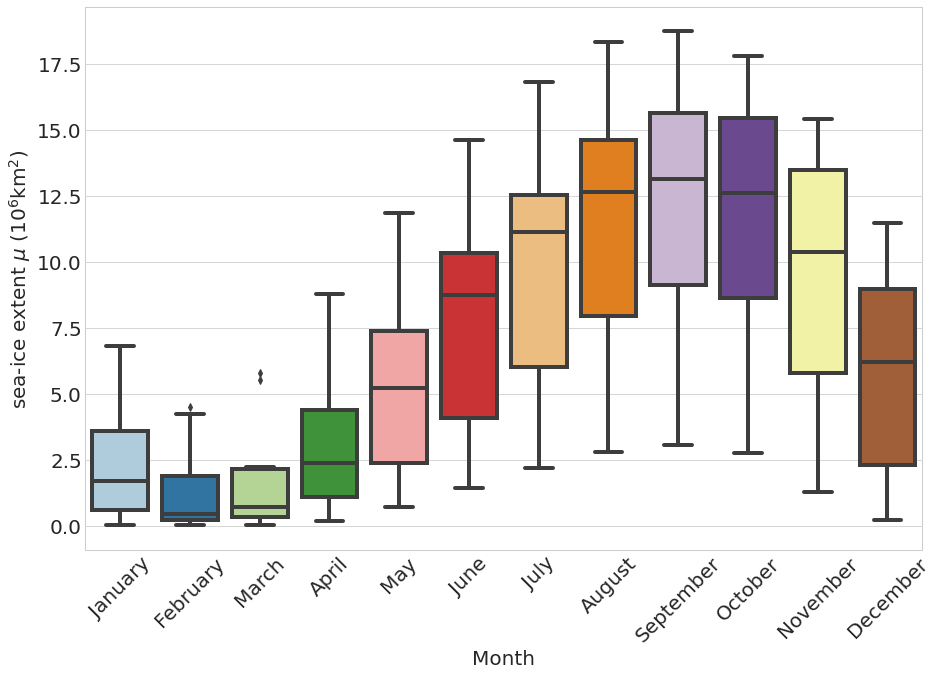

In [40]:
ax = sns.boxplot(data=pd.DataFrame(mus))
ax.set_xlabel("Month")
ax.set_ylabel(r"sea-ice extent $\mu$ ($10^6$km$^2$)")
ax.set_xticks(np.arange(12))
ax.set_xticklabels(list(seasons.keys()), rotation=45)

## Intermodel spread explained by ECS

In [59]:
print(siArea.keys())
model="CESM2"
hem = "siareaN"
exp="ssp370"

dict_keys(['ACCESS-ESM1-5', 'ACCESS-CM2', 'CNRM-CM6-1', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'CESM2', 'MPI-ESM', 'MIROC6', 'CanESM5i1p1f1', 'CanESM5_i1p2f1', 'MIROC-ES2L'])


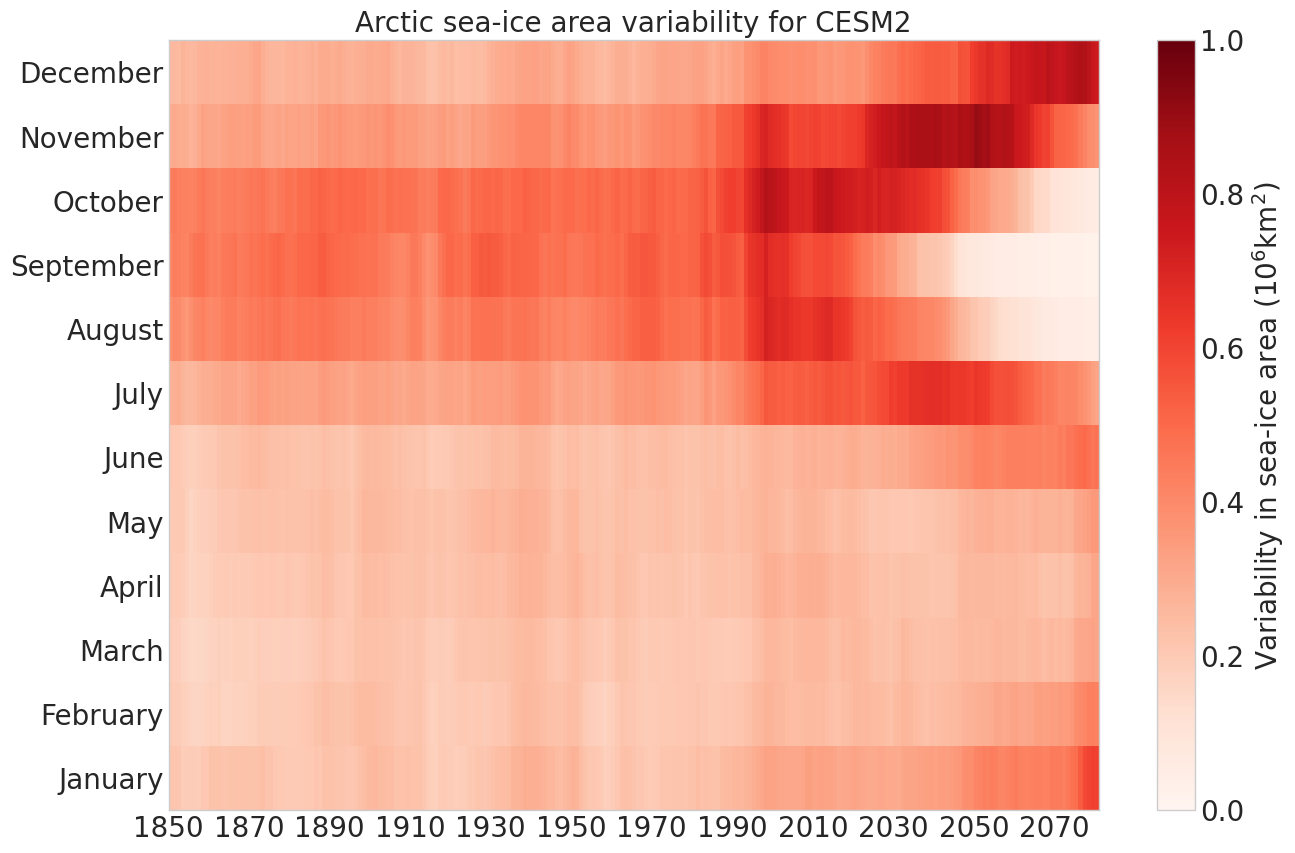

In [60]:
nmonths, nyears = siArea[model][hem][exp]["std"].shape

img = plt.pcolormesh(siArea[model][hem][exp]["std"], label=f"{model} {exp}", cmap="Reds")
plt.yticks(np.arange(.5, 12.5), list(seasons.keys()))
plt.xticks(np.arange(0,nyears,20), np.arange(0+1850, nyears+1850, 20)) 
plt.title(f"Arctic sea-ice area variability for {model}")
cbar = plt.colorbar(label=r"Variability in sea-ice area ($10^6$km$^2$)")
plt.clim(0, 1.0)
plt.savefig(f"Arctic_ASIEV_{model}_trends.png")

# MISC

ACCESS-ESM1-5 ssp126 failed! 

ACCESS-ESM1-5 ssp245 failed! 

ACCESS-ESM1-5 ssp370 failed! 

ACCESS-ESM1-5 ssp585 failed! 



ValueError: v cannot be empty

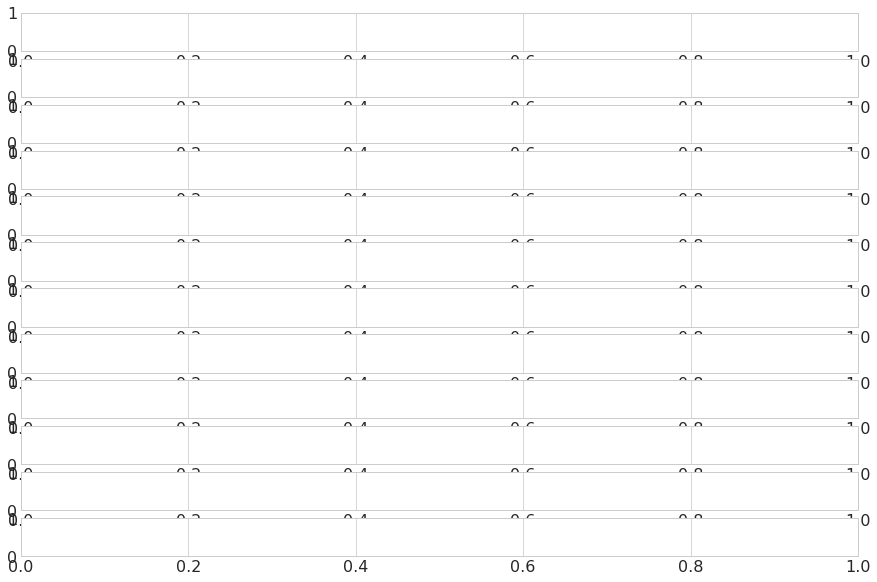

In [ ]:
fig, axs = plt.subplots(len(list(meta.keys())) + 1, 1)
season = "summer"
hem = "siareaN"
window = 20
for i, model in enumerate(meta.keys()):
    mean_total = []
    std_total = []
    for exp in exps: 
        if exp not in siArea[model][hem].keys(): continue
        try: 
            mean = siArea[model][hem][exp]["mean"][season]
            std = siArea[model][hem][exp]["std"][season]
            mean_total = mean_total + list(mean)
            std_total = std_total + list(std)
            nens, _ = siArea[model][hem][exp]["data"].shape
            axs[i].plot(mean, std, label=f"{model} {exp} (n={nens})")    
        except Exception as err:
            print(f"{model} {exp} failed! \n")
            
    p = np.array(mean_total).argsort()
    mean_total = moving_average(np.array(mean_total)[p], w=window)
    std_total = moving_average(np.array(std_total)[p], w=window)

    # Save max STD and location of max STD for future use
    idx = np.argmax(std_total)
    meta[model]["stdMax"] = std_total[idx]
    meta[model]["meanMax"] = mean_total[idx]

    axs[i].plot(mean_total, std_total, label=f"Total (smoothed={window})", color="black")
    axs[-1].plot(mean_total, std_total, label=f"{model}")
    ecs = meta[model]["ecs"]       
    axs[i].legend()
    axs[i].set_xlabel(r"Mean 10$^6$ km$^2$")
    axs[i].set_ylabel(r"$\sigma$ (10$^6$ km$^2$)")
    axs[i].set_title(f"{model}, ECS={ecs}", loc="right")

axs[-1].legend()
axs[-1].set_xlabel(r"Mean 10$^6$ km$^2$")
axs[-1].set_ylabel(r"$\sigma$ (10$^6$ km$^2$)")
# plt.suptitle(f"Arctic STD Interannual Summer SIA (window={W})")
fig.set_size_inches(20, 80)
plt.savefig("Arctic_Summer_SIEV.png")

## Feedbacks

## REDO CanESM5 and MIROC-ESLM

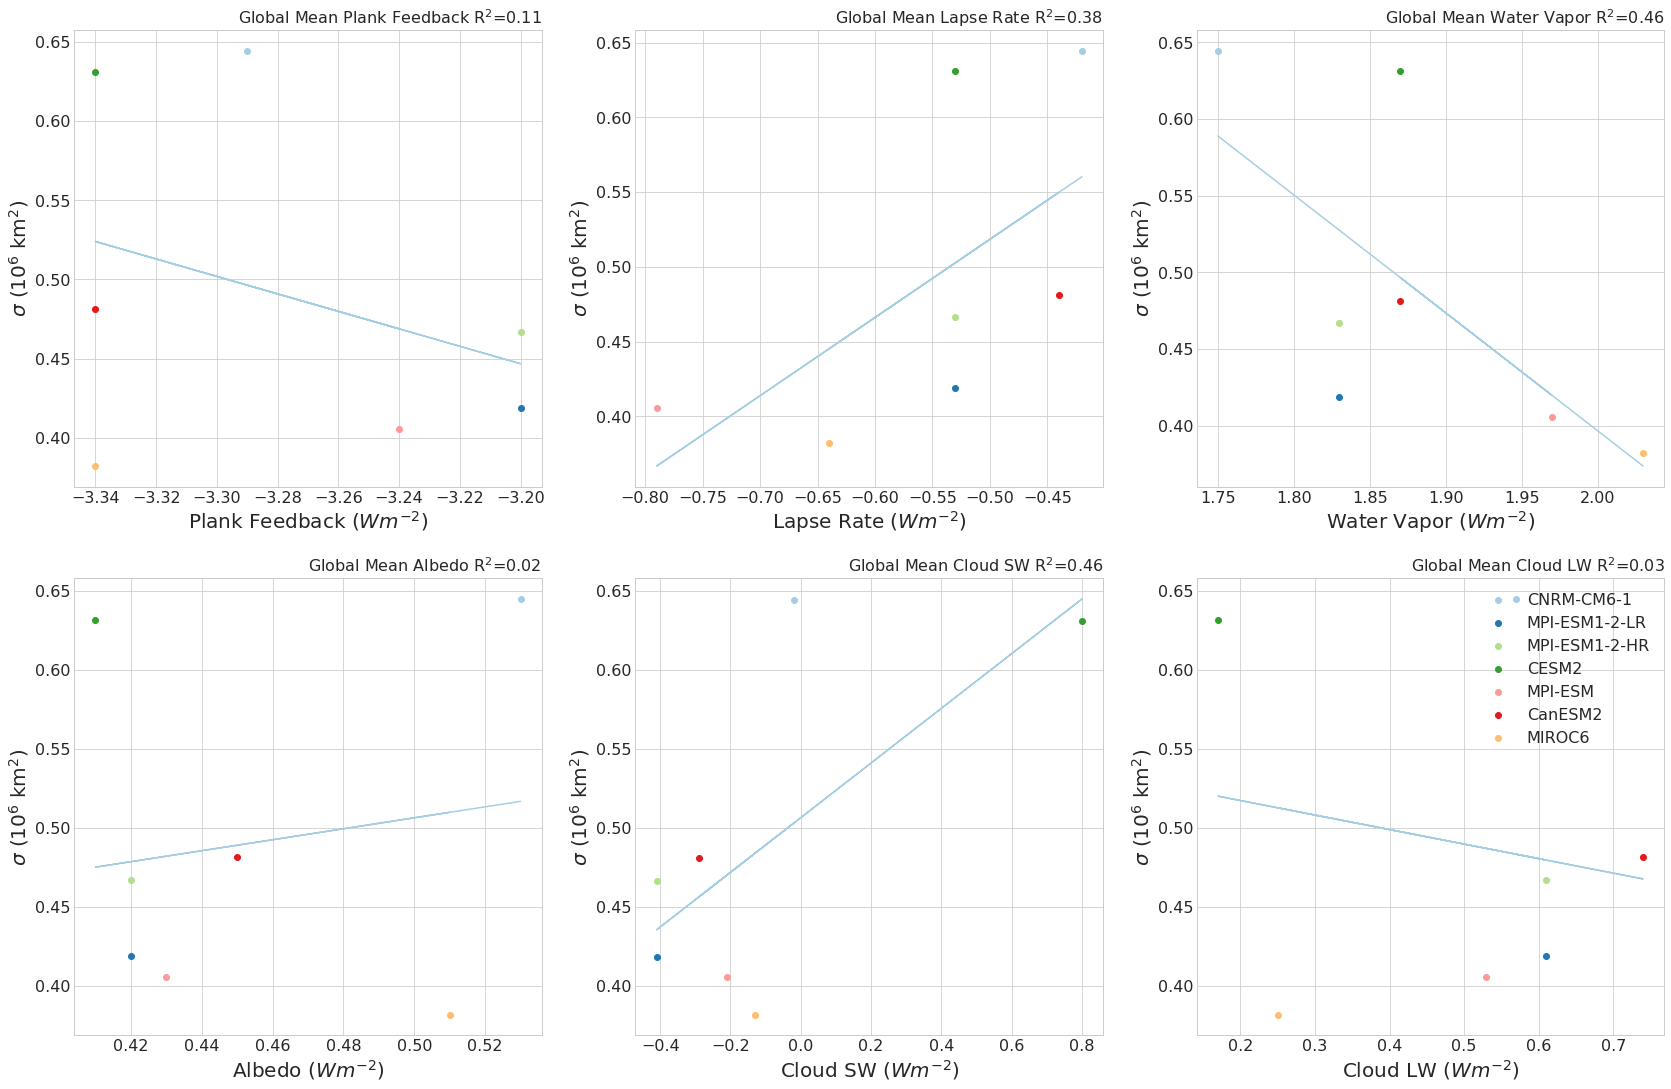

In [71]:
fbs = ["pl","lr","wv", "alb", "cld_sw", "cld_lw"]
titles = ["Plank Feedback", "Lapse Rate", "Water Vapor", "Albedo", "Cloud SW", "Cloud LW"]
season = "summer"
hem = "siareaN"

fig, axs = plt.subplots(2, 3)

for k, fb in enumerate(fbs):
    i, j = int(k / 3), int(k % 3)
    fb_values = []
    for m, model in enumerate(models): 
        if model == "ACCESS-ESM1-5" or model == "ACCESS-CM2": continue
        # try: 
        
        fb_values.append(meta[model][fb])
        axs[i,j].scatter(meta[model][fb], maxSTD[m], label=model)
        axs[i,j].set_xlabel(f"{titles[k]}" + r" ($Wm^{-2}$)")
        axs[i,j].set_ylabel(r"$\sigma$ (10$^6$ km$^2$)")
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(fb_values, maxSTD[2:])
    axs[i,j].set_title(f"Global Mean {titles[k]}" + f" R$^2$={np.around(r_value**2,2)}",loc="right")
    axs[i,j].plot(fb_values, slope*np.array(fb_values) + intercept)

            
        # except Exception as err:
            # print(f"{model} failed! \n")
plt.legend()
fig.set_size_inches(28.5, 18.5)

## Resolution